In [1]:
%load_ext autoreload
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from feature_engine.selection import SmartCorrelatedSelection

In [2]:
def has_na(df: pd.DataFrame):
    return df.isna().sum()
def has_dupl(df: pd.DataFrame):
    return df.duplicated().sum()
def check_df(df: pd.DataFrame):
    print(f"[*] Checking for NA: \n{has_na(df)} \n\n[*] Duplicated: {has_dupl(df)}")

def get_na(df :pd.DataFrame): 
    return df[df.isnull().any(axis=1)]

# Understanding the data
Types of variables and descriptive statistics

In [3]:
data = pd.read_csv('housing.csv')

In [4]:
data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [5]:
data.columns = data.columns.str.replace('latitude', 'lat')
data.columns = data.columns.str.replace('longitude', 'lon')

In [6]:
data

,lon,lat,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   lon                 20640 non-null  float64
 1   lat                 20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
check_df(data)

[*] Checking for NA: 
lon                     0
lat                     0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64 

[*] Duplicated: 0


Here you can see that most of the initial features are numerical. Only proximity to the ocean is a categorical attribute

In [9]:
num_features = data.select_dtypes('number')
cat_features = data.drop(columns=num_features)

print(f'Numerical variables: \n {num_features.columns.values}\n')
print(f'Categorical variables: \n {cat_features.columns.values}')

Numerical variables: 
 ['lon' 'lat' 'housing_median_age' 'total_rooms' 'total_bedrooms'
 'population' 'households' 'median_income' 'median_house_value']

Categorical variables: 
 ['ocean_proximity']


In [10]:
data.nunique().sort_values()

ocean_proximity           5
housing_median_age       52
lon                     844
lat                     862
households             1815
total_bedrooms         1923
median_house_value     3842
population             3888
total_rooms            5926
median_income         12928
dtype: int64

In [11]:
max_age = data.housing_median_age.max()
min_age = data.housing_median_age.min()

print(f"The average ages of real estate (from the buildings) are between {min_age} and {max_age} years")

The average ages of real estate (from the buildings) are between 1.0 and 52.0 years


In [12]:
max_value = data.median_house_value.max()
min_value = data.median_house_value.min()

print(f"The average property prices are among {min_value} and {max_value}")

The average property prices are among 14999.0 and 500001.0


In [13]:
data.ocean_proximity.unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [14]:
data.ocean_proximity.value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

Summary on Quantitative Variables:

In [15]:
data.describe().drop(columns=['lon', 'lat']).T

,count,mean,std,min,25%,50%,75%,max
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


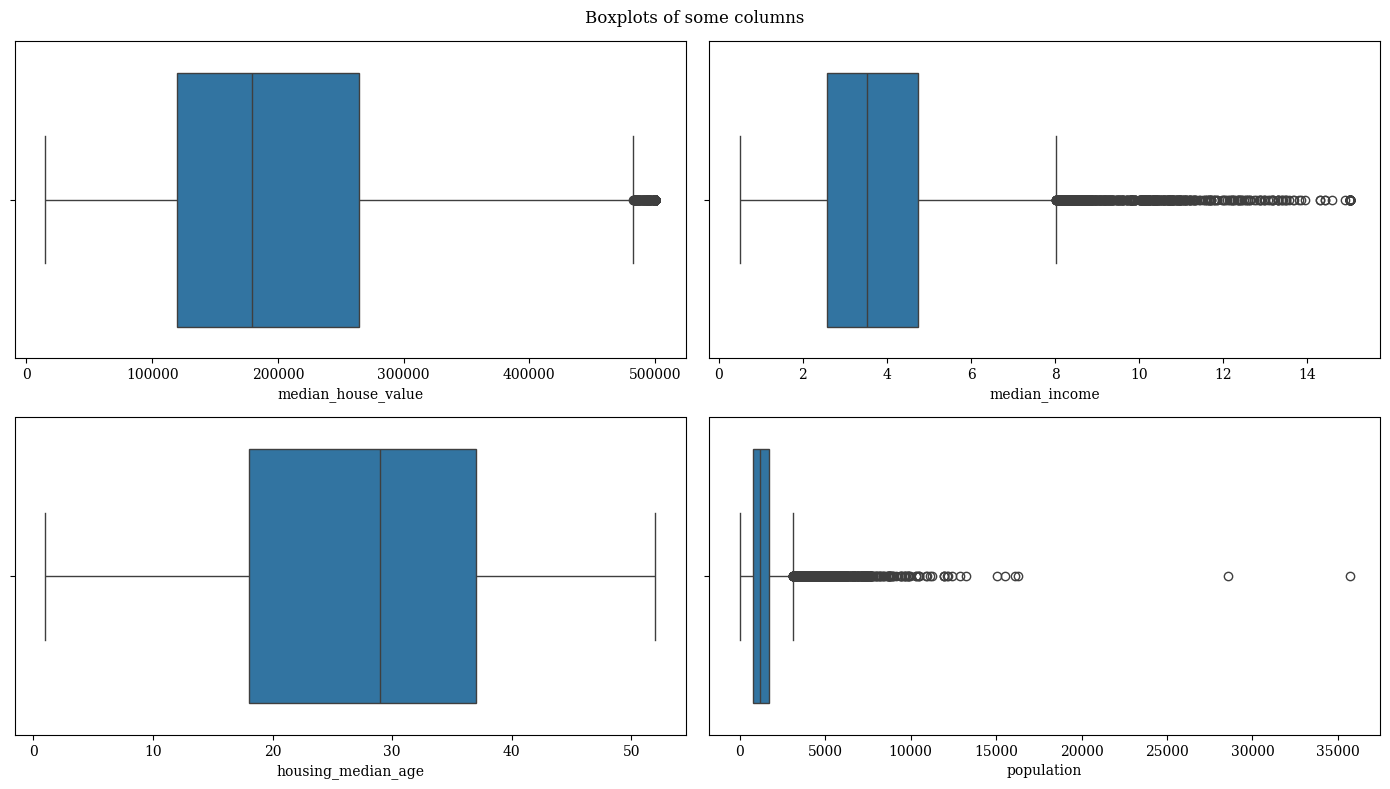

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

cols = ['median_house_value', 'median_income', 'housing_median_age', 'population']

for i, col in enumerate(cols):
    _ = sns.boxplot(data=data, x=col, ax=axes[i])
fig.suptitle('Boxplots of some columns')
fig.tight_layout()

Here, it can be observed that the column <code>median_income</code> has a considerable number of <i>outliers</i> and <code>population</code> has many <i>outliers</i>.

Higher prices:

In [17]:
data.median_house_value.nlargest(10)

89     500001.0
459    500001.0
493    500001.0
494    500001.0
509    500001.0
510    500001.0
511    500001.0
512    500001.0
514    500001.0
517    500001.0
Name: median_house_value, dtype: float64

Higher rent:

In [18]:
data.median_income.nlargest(10)

1566    15.0001
4352    15.0001
4604    15.0001
4605    15.0001
4606    15.0001
4626    15.0001
4678    15.0001
5242    15.0001
5247    15.0001
5248    15.0001
Name: median_income, dtype: float64

Here we can see that probably these two data on a predetermined scale, this is important so that in the future the algorithm does not mislead that there is a limit.

In [19]:
data.query(f"median_income in {data.median_income.nsmallest(3).to_list()} or population in {data.population.nlargest(3).to_list()}")

,lon,lat,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
73,-122.29,37.81,46.0,12.0,4.0,18.0,7.0,0.4999,67500.0,NEAR BAY
3249,-119.99,36.09,23.0,333.0,92.0,198.0,55.0,0.4999,100000.0,INLAND
3258,-122.89,39.42,16.0,411.0,114.0,26.0,19.0,0.4999,73500.0,INLAND
4861,-118.28,34.02,29.0,515.0,229.0,2690.0,217.0,0.4999,500001.0,<1H OCEAN
5213,-118.28,33.93,52.0,117.0,33.0,74.0,45.0,0.4999,90600.0,<1H OCEAN
6343,-117.75,34.06,52.0,62.0,9.0,44.0,16.0,0.4999,112500.0,INLAND
6688,-118.08,34.15,28.0,238.0,58.0,142.0,31.0,0.4999,500001.0,INLAND
7125,-118.04,33.90,36.0,15.0,5.0,15.0,6.0,0.4999,162500.0,<1H OCEAN
9880,-121.79,36.64,11.0,32627.0,6445.0,28566.0,6082.0,2.3087,118800.0,<1H OCEAN
13139,-121.44,38.43,3.0,39320.0,6210.0,16305.0,5358.0,4.9516,153700.0,INLAND


We can see places where the average price is very high but the income is low.

In [20]:
data.query("total_bedrooms > total_rooms")

,lon,lat,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity


It would not make sense to have more bedrooms than total rooms

In [21]:
data.query("households > population")

,lon,lat,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
5342,-118.44,34.04,16.0,18.0,6.0,3.0,4.0,0.5360,350000.0,<1H OCEAN
11849,-121.00,39.75,8.0,1116.0,214.0,27.0,39.0,2.5893,83000.0,INLAND
19522,-121.00,37.65,17.0,484.0,202.0,198.0,204.0,0.6825,187500.0,INLAND


# Exploratory Data Analysis (EDA)
Analyzing, investigating the data and describing its main characteristics.
<hr>

### Univariate analysis (Exploring each variable separately)
Numerical features

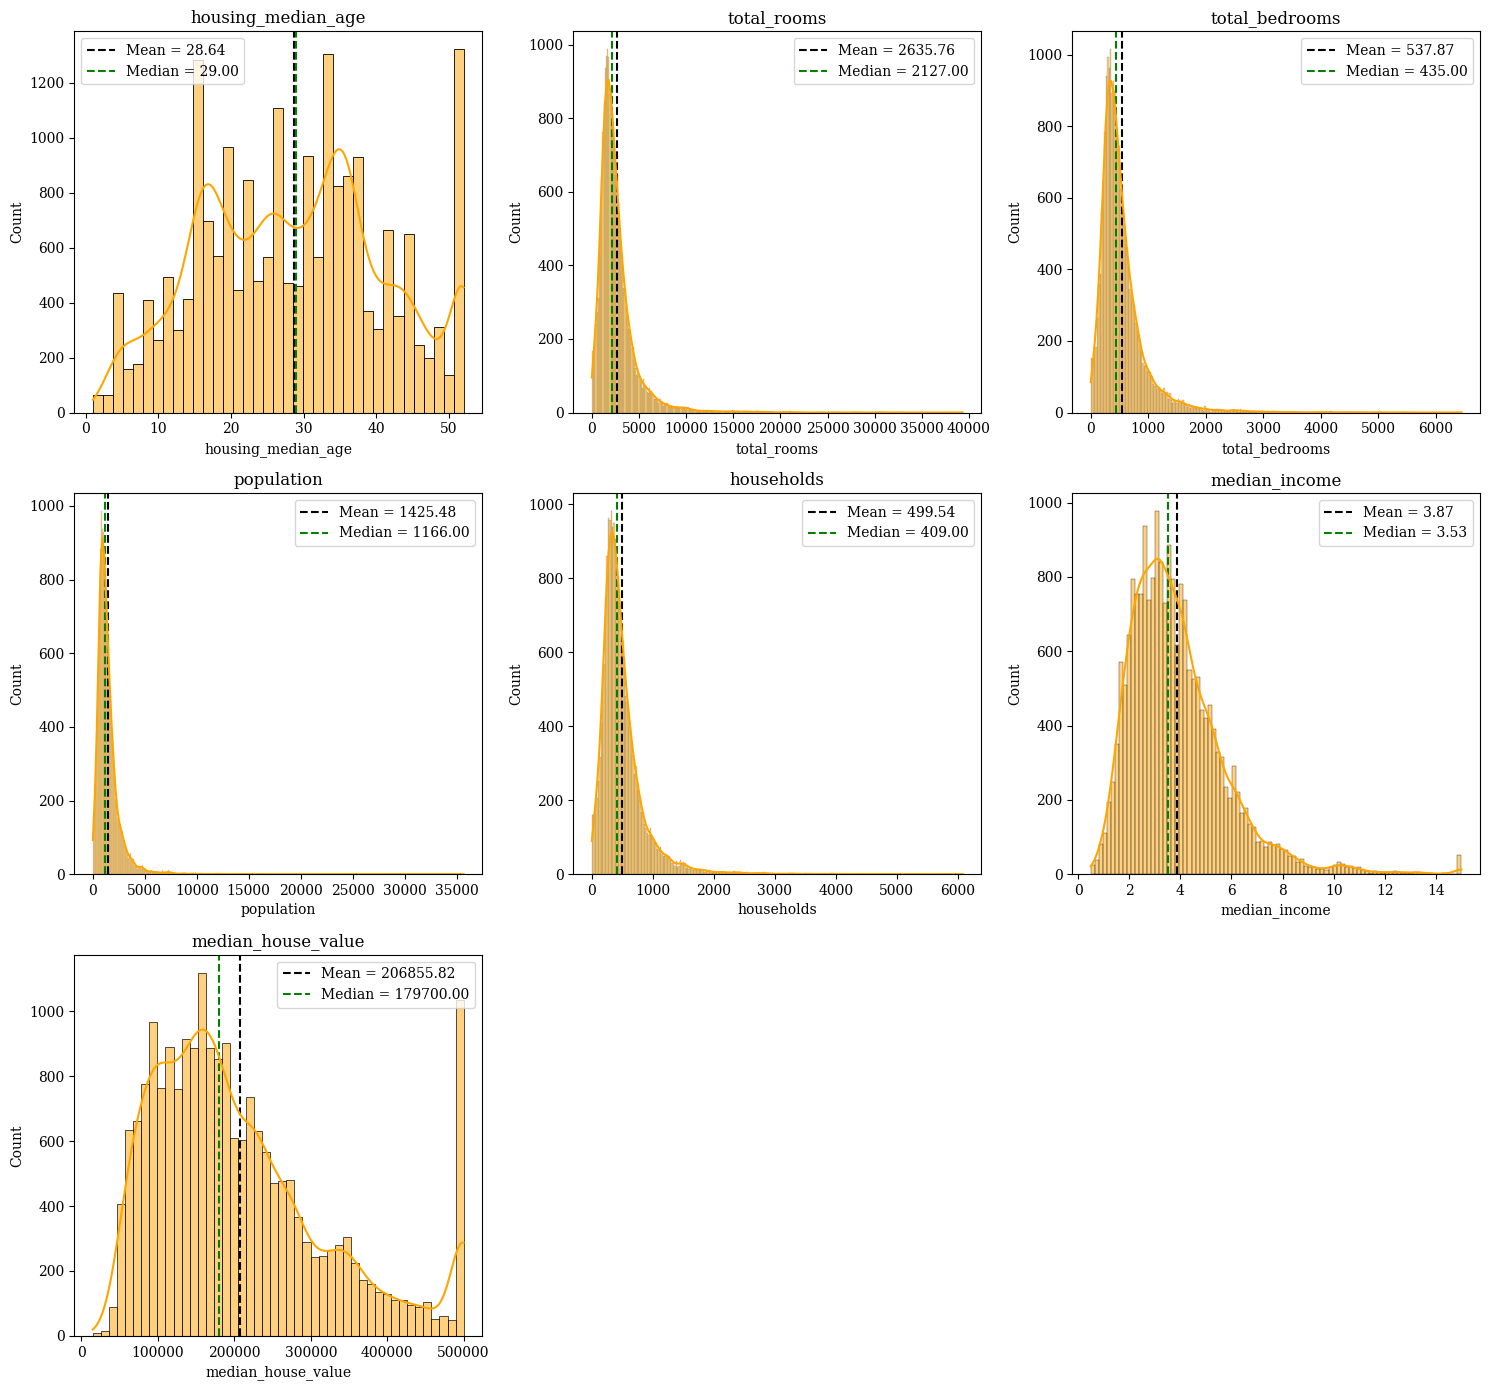

In [22]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 14))
axes = axes.flatten()

for i, column in enumerate(num_features.drop(columns=['lat', 'lon'])):
    mean_val = data[column].mean()
    median_val = data[column].median()
    axes[i].axvline(mean_val, color='black', linestyle='--', label=f'Mean = {mean_val:.2f}')
    axes[i].axvline(median_val, color='green', linestyle='--', label=f'Median = {median_val:.2f}')

    axes[i].legend()


    sns.histplot(data=data,x=column, ax=axes[i], kde=True, color='orange')
    axes[i].set_title(column, fontfamily='serif')

plt.yticks()
fig.delaxes(axes[-1])
fig.delaxes(axes[-2])
fig.tight_layout()

Most of the columns are right-skewed, indicating that the average is higher than the median. In these cases, the median captures the values that appear the best.

We can also see that there is an abnormal value of properties priced around 500,000 (in the <code>median_house_value</code> column), as noted earlier.

#### <i>Categorical feature</i>

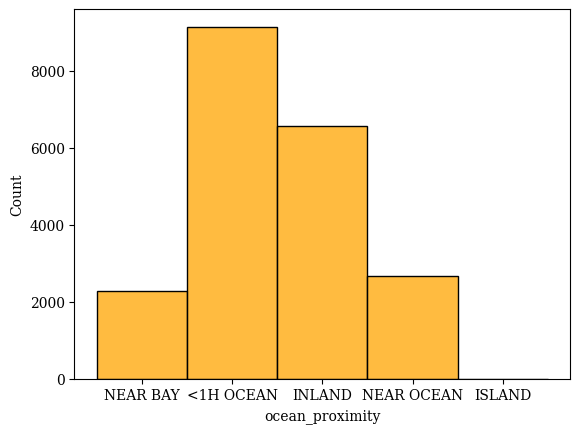

In [23]:
_ = sns.histplot(data=cat_features, x='ocean_proximity', color='orange')

Houses less than one hour away from the ocean are the trend

### Bivariate analysis
Analyzing two separate variables and determining whether they are related

In [24]:
data.columns

Index(['lon', 'lat', 'housing_median_age', 'total_rooms', 'total_bedrooms',
       'population', 'households', 'median_income', 'median_house_value',
       'ocean_proximity'],
      dtype='object')

In [25]:
def plot_corr_heatmap(data= pd.DataFrame, fig_size=(12, 10)):
    _ = plt.figure(figsize=fig_size)

    # mask to "remove" the squares in the upper triangle
    mask = np.triu(np.ones_like(data.corr(), dtype=bool))

    heatmap = sns.heatmap(data.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
    heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':14})
    plt.tight_layout()

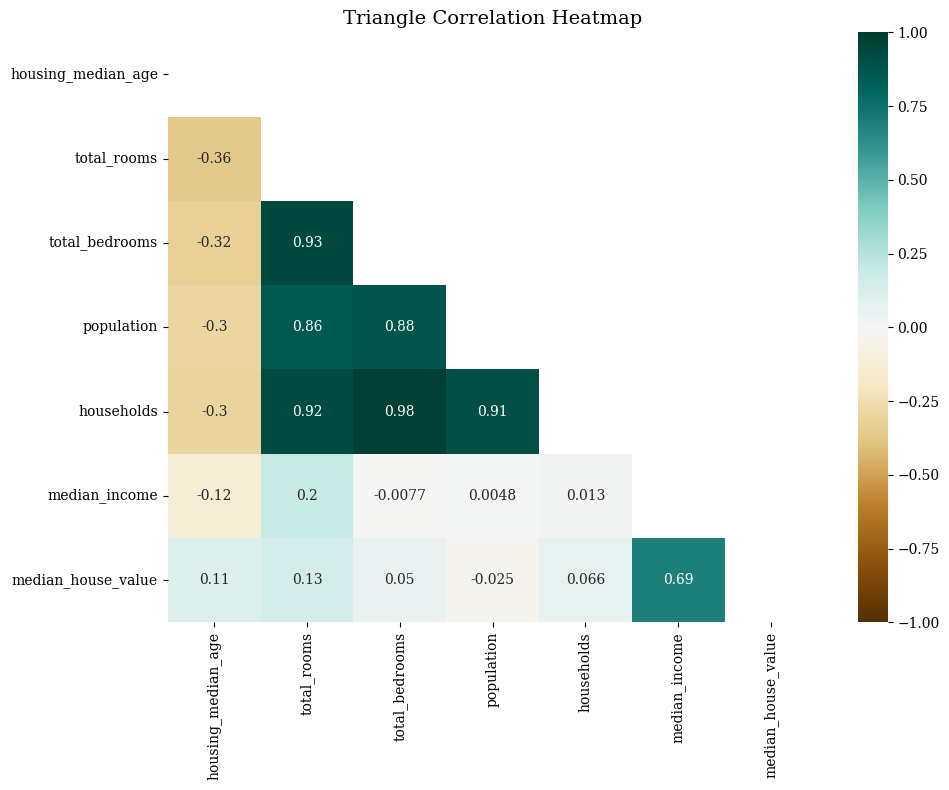

In [26]:
plot_corr_heatmap(data.select_dtypes(include=[np.number]).drop(columns=['lat', 'lon']), fig_size=(10, 8))

Further analysis between households and rooms:

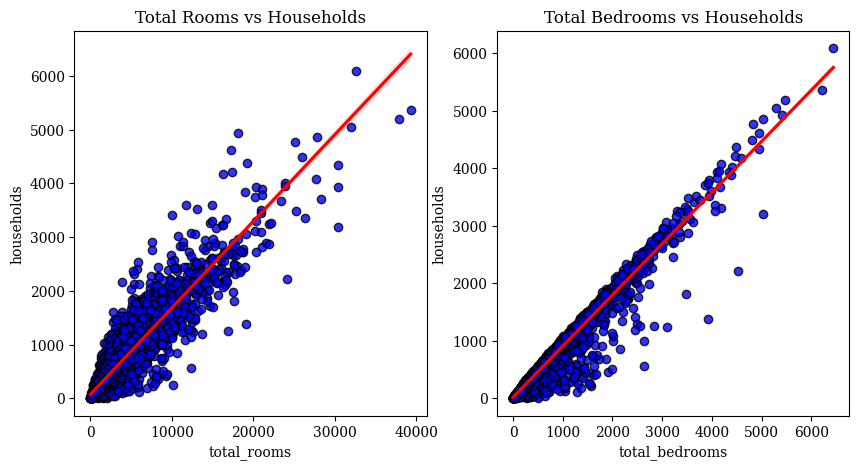

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.flatten()
_ = sns.regplot(data=data, x='total_rooms', y='households', scatter_kws={"color": "blue", "edgecolor":"k" },
           line_kws={"color": "red"}, ax=axes[0])
_ = axes[0].set_title('Total Rooms vs Households')
_ = sns.regplot(data=data, x='total_bedrooms', y='households', scatter_kws={"color": "blue", "edgecolor":"k"},
           line_kws={"color": "red"}, ax=axes[1])
_ = axes[1].set_title('Total Bedrooms vs Households')

A very strong linear relationship between homes and rooms can be oserved from the above

### Where are the houses concentrated?

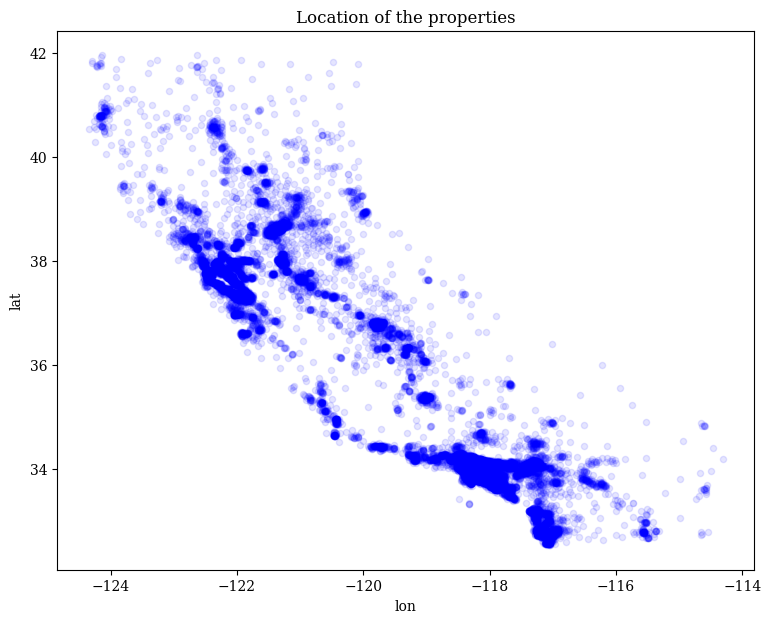

In [28]:
_ = data.plot(kind="scatter", x="lon", y="lat", alpha=0.1, figsize=(9, 7), c='blue')
_ = plt.title('Location of the properties')

It can be observed that the houses are concentrated in the coastal area

### What are the effects of proximity to the sea?

In [29]:
data.groupby("ocean_proximity").housing_median_age.agg(mean_median_age='mean', median_median_age='median', std_median_age = 'std', max_median_age = 'max', min_median_age = 'min').reset_index().sort_values(by='mean_median_age')

,ocean_proximity,mean_median_age,median_median_age,std_median_age,max_median_age,min_median_age
1,INLAND,24.271867,23.0,12.018020,52.0,1.0
0,<1H OCEAN,29.279225,30.0,11.644453,52.0,2.0
4,NEAR OCEAN,29.347254,29.0,11.840371,52.0,2.0
3,NEAR BAY,37.730131,39.0,13.070385,52.0,2.0
2,ISLAND,42.400000,52.0,13.164346,52.0,27.0


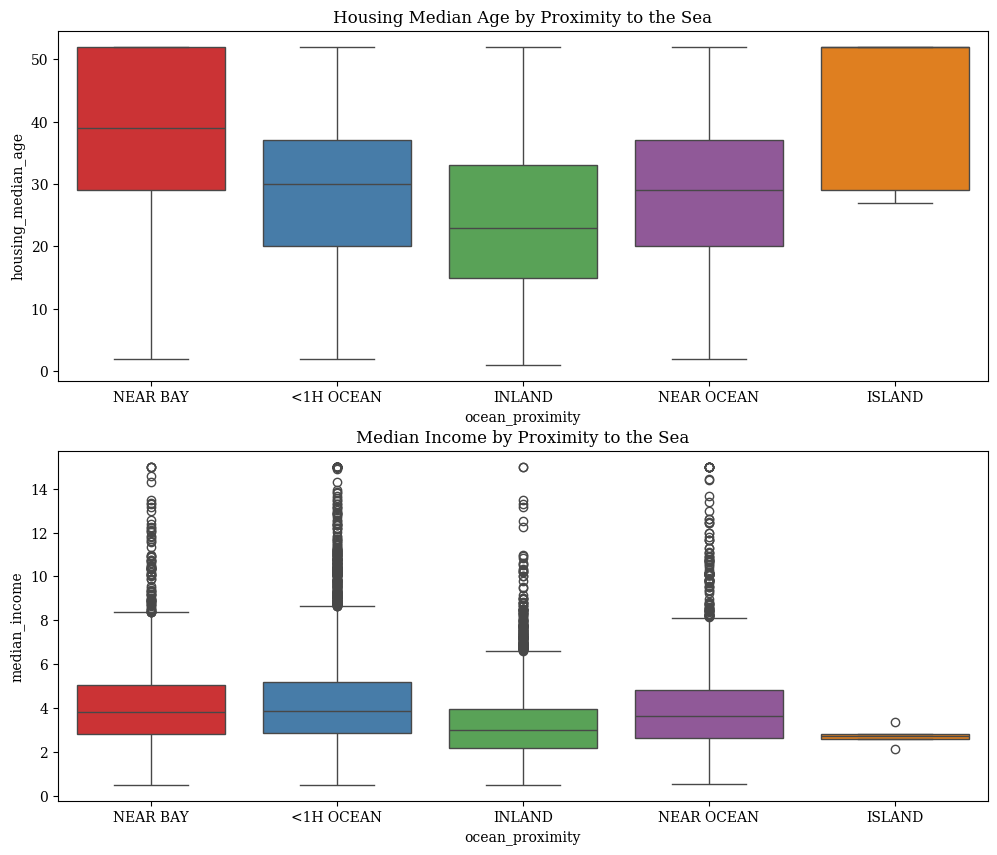

In [30]:
fig, axes = plt.subplots(2, figsize=(12, 10))
axes = axes.flatten()

_ = sns.boxplot(data=data, x='ocean_proximity', y='housing_median_age', ax=axes[0], palette='Set1', hue='ocean_proximity', legend=False)
_ = axes[0].set_title('Housing Median Age by Proximity to the Sea')

_ = sns.boxplot(data=data, x='ocean_proximity', y='median_income', ax=axes[1], palette='Set1', hue='ocean_proximity', legend=False)
_ = axes[1].set_title('Median Income by Proximity to the Sea')



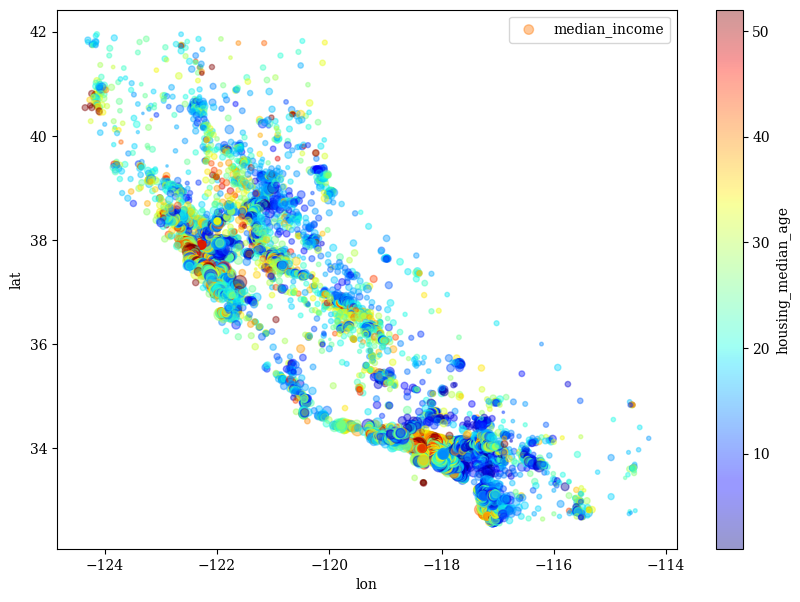

In [31]:
_ = data.plot(kind="scatter", x="lon", y="lat", alpha=0.4, label="median_income", figsize=(10,7), 
        c="housing_median_age",s=data.median_income*6, cmap=plt.get_cmap("jet"), colorbar=True)
_ = plt.legend()

Older properties are located near the sea. If you stop to reflect, it is common for older buildings to be located on the coast.

In addition living on the coast is more expensive, requiring a higher income.

In [32]:
data.groupby('ocean_proximity').agg(
    {'households': ['mean', 'median', 'std', 'sum'],
     'population': ['mean', 'median', 'std', 'sum']}
)

households                                 population  \
                       mean median         std        sum         mean   
ocean_proximity                                                          
<1H OCEAN        517.744965  421.0  392.280718  4730118.0  1520.290499   
INLAND           477.447565  385.0  392.252095  3127759.0  1391.046252   
ISLAND           276.600000  288.0  113.200265     1383.0   668.000000   
NEAR BAY         488.616157  406.0  350.598369  1118931.0  1230.317467   
NEAR OCEAN       501.244545  429.0  344.445256  1332308.0  1354.008653   

                                                  
                 median          std         sum  
ocean_proximity                                   
<1H OCEAN        1247.0  1185.848357  13889374.0  
INLAND           1124.0  1168.670126   9112744.0  
ISLAND            733.0   301.691067      3340.0  
NEAR BAY         1033.5   885.899035   2817427.0  
NEAR OCEAN       1136.5  1005.563166   3598955.0

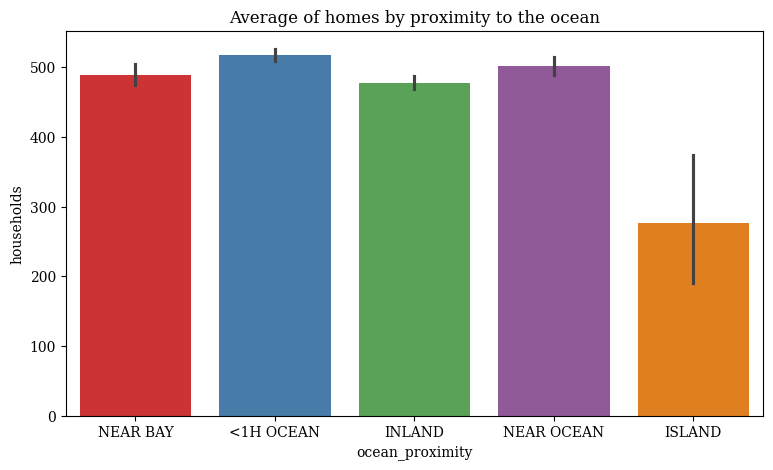

In [33]:
plt.figure(figsize=(9, 5))

_ = sns.barplot(data=data, x='ocean_proximity', y='households', palette='Set1', hue='ocean_proximity', dodge=False, legend=False)

_ = plt.title('Average of homes by proximity to the ocean')

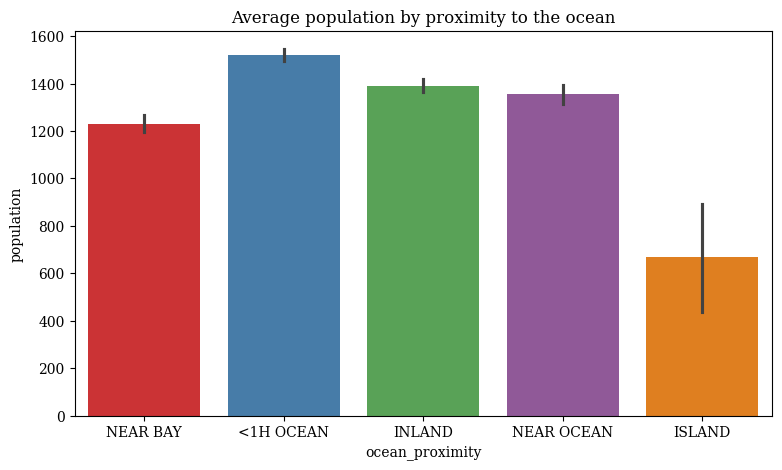

In [34]:
f = plt.figure(figsize=(9, 5))
_ = sns.barplot(data=data, x='ocean_proximity', y='population',  palette='Set1', hue='ocean_proximity', dodge=False, legend=False)
_ = plt.title('Average population by proximity to the ocean')

# Analysis of the median value of real estate (alvo)

What attributes relate to our target?
<hr>

Does the proximity to the ocean influence the value of the property?

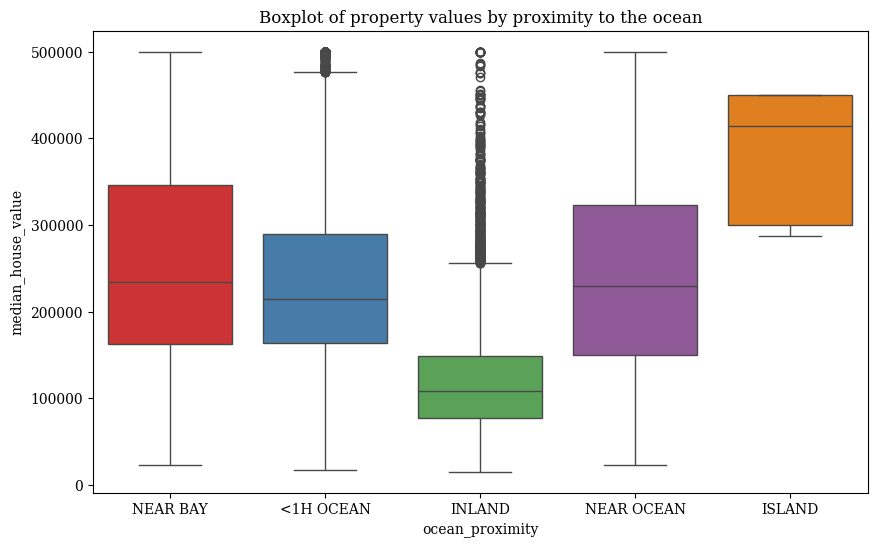

In [35]:
f = plt.figure(figsize=(10,6))
_ = sns.boxplot(data=data, x='ocean_proximity', y='median_house_value', palette='Set1', hue='ocean_proximity', dodge=False, legend=False)
_ = plt.title('Boxplot of property values by proximity to the ocean')

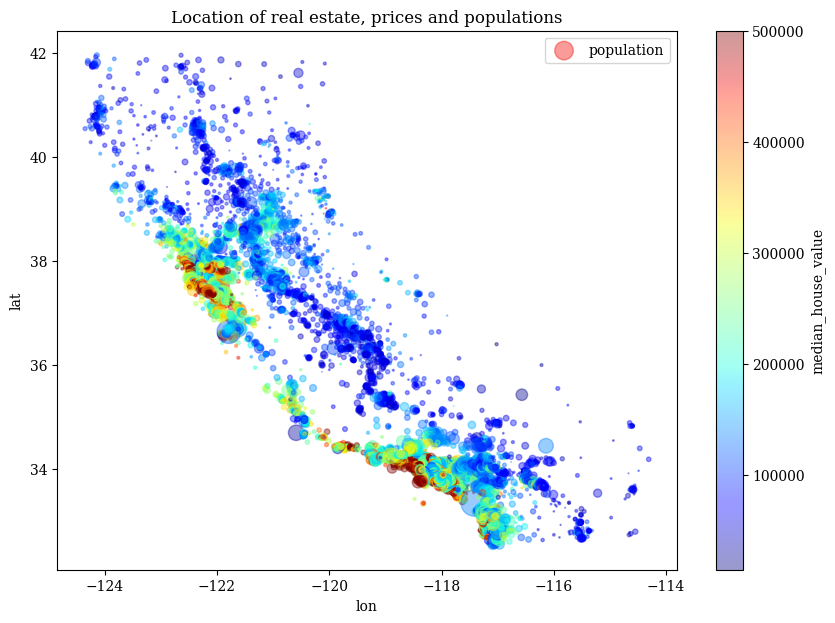

In [36]:
_ = data.plot(kind="scatter", x="lon", y="lat", alpha=0.4,     
        s=data["population"]/100, label="population", figsize=(10,7), 
        c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
_ = plt.title('Location of real estate, prices and populations')
_ = plt.legend()

On the coast, the properties are more expensive. The centers are usually located on the coast (such as the city of Los Angeles) and they have more people in search of housing, which increases the value of them.

#### Is there a relationship between rent and the price of the property?

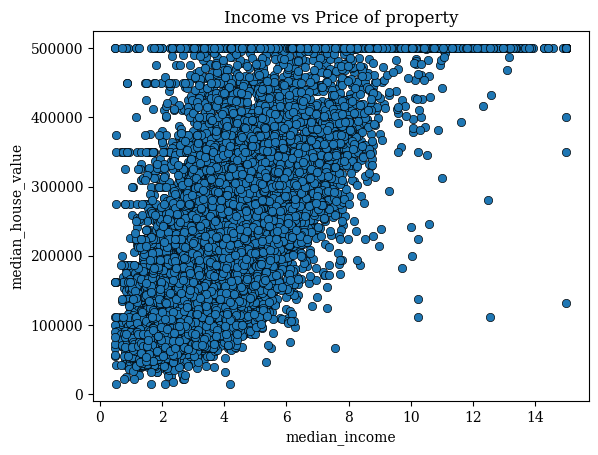

In [37]:
_ = sns.scatterplot(data=data, x='median_income', y='median_house_value', edgecolor='k')
_ = plt.title('Income vs Price of property')

There seems to be a positive relationship between income and property prices. It is also possible to observe the limit of 500 thousand in the property value as indicated earlier.

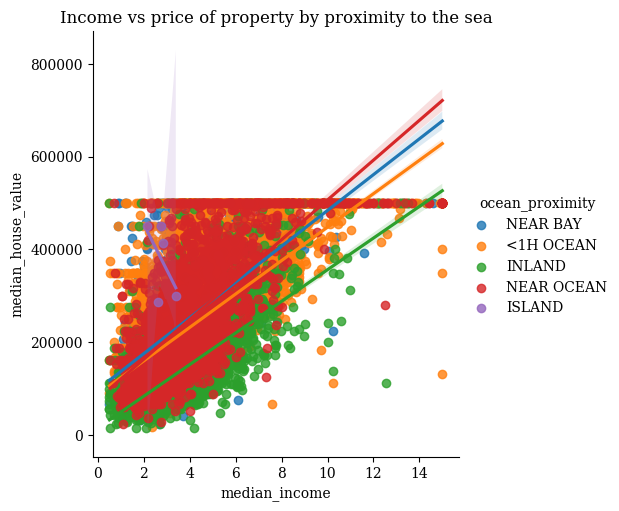

In [38]:
_ = sns.lmplot(data=data, x='median_income', y='median_house_value', hue='ocean_proximity')
_ = plt.title('Income vs price of property by proximity to the sea')

The closer to the coast, the greater the slope of the straight.

#### Is there a relationship between the population and the value of the property?

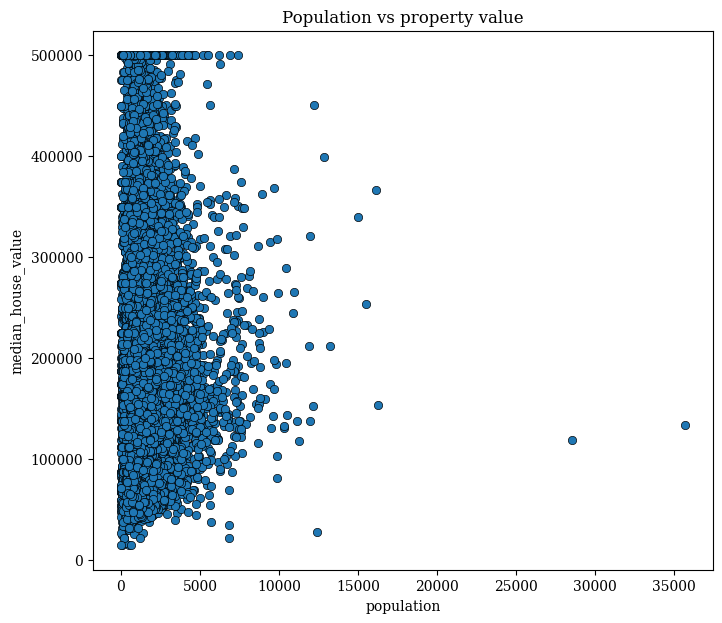

In [39]:
_ = plt.figure(figsize=(8,7))
_ = sns.scatterplot(data=data, x='population', y='median_house_value', edgecolor='k')
_ = plt.title('Population vs property value')

There seems to be no relationship between the population of the locality and the value of the property.

# Feature Engeering

Adding new features: distance to the ocean, nearest city and others.
<hr>

To improve the quality of information, we will get the distance from the <b>house to the ocean</b> with the coordinates of the housing and the coastline. We will also calculate the city closest to that town (center of the city) and the <b>distance to the city center</b>. In addition, we will add other information such as <b>the number of rooms per household, number of people per family, and number of bedrooms per room</b>.

In [40]:
import geopandas as gpd
import contextily as ctx

CRS='EPSG:4326'

#  transforming the coordinates into points that the geopandas can read
geometry_housing = gpd.points_from_xy(data['lon'], data['lat'])
points_housing = gpd.GeoDataFrame(data)
points_housing = points_housing.set_geometry(geometry_housing)
points_housing.set_crs(CRS, inplace=True)

print(points_housing.crs)
points_housing.head(5)

EPSG:4326


,lon,lat,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,geometry
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,POINT (-122.23 37.88)
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,POINT (-122.22 37.86)
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,POINT (-122.24 37.85)
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,POINT (-122.25 37.85)
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,POINT (-122.25 37.85)


## Distance to the Ocean

To calculate the distance from the property to the coast, use the downloaded geographical data of the west coast of the United States and with the <code>GeoPandas</code> library calculate the distance from each coordinate of the dataset.

In [41]:
coastline = gpd.read_file('data/coastline/US_Westcoast.shp')[['geometry']]

# transforming the global coordinate system
coastline.to_crs(CRS, inplace=True)
coastline.head(5)

,geometry
0,"LINESTRING (-121.74192 36.2077, -121.74058 36...."
1,"LINESTRING (-121.54138 36.01699, -121.54364 36..."
2,"LINESTRING (-121.46864 35.92556, -121.46909 35..."
3,"LINESTRING (-121.46864 35.92556, -121.46864 35..."
4,"LINESTRING (-121.01394 35.46982, -121.01484 35..."


In [42]:
DISTANCE_CRS = 32643
nearest_coastline = gpd.sjoin_nearest(points_housing.to_crs(crs=DISTANCE_CRS), coastline.to_crs(crs=DISTANCE_CRS), distance_col = 'distance_to_ocean')
nearest_coastline.to_crs(CRS, inplace=True)
nearest_coastline = nearest_coastline[~nearest_coastline.index.duplicated(keep='first')]
nearest_coastline

,lon,lat,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,geometry,index_right,distance_to_ocean
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,POINT (-122.23 37.88),3096,6979.824209
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,POINT (-122.22 37.86),3099,7369.779837
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,POINT (-122.24 37.85),3099,5377.567036
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,POINT (-122.25 37.85),3099,4481.739385
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,POINT (-122.25 37.85),3099,4481.739385
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND,POINT (-121.09 39.48),1614,81419.596156
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND,POINT (-121.21 39.49),1597,72517.251055
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND,POINT (-121.22 39.43),1597,68802.034512
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND,POINT (-121.32 39.43),1597,60783.943025


In [43]:
points_housing = nearest_coastline.drop(columns=['index_right'])

In [44]:
# checking null values using the created function
get_na(points_housing[['distance_to_ocean']])

,distance_to_ocean


No duplicates were found

## The nearest city

Use a .csv file that has the geographic coordinates of California cities. Then perform a join with the coordinates of the properties and get the cities closest to the locality.

In [45]:
california_cities = pd.read_csv('utils/cal_cities_lat_long.csv')
california_cities.head(5)

,Name,Latitude,Longitude
0,Adelanto,34.582769,-117.409214
1,Agoura Hills,34.153339,-118.761675
2,Alameda,37.765206,-122.241636
3,Albany,37.886869,-122.297747
4,Alhambra,34.095286,-118.127014


In [46]:
# reading the coordinates from longitude (x) and latitude (y) and turning into points.
geometry_cal = gpd.points_from_xy(california_cities['Longitude'], california_cities['Latitude'])

# creating a dataframe from these points
points_cal = gpd.GeoDataFrame(california_cities, geometry=geometry_cal)
points_cal.set_crs(CRS, inplace=True)

,Name,Latitude,Longitude,geometry
0,Adelanto,34.582769,-117.409214,POINT (-117.40921 34.58277)
1,Agoura Hills,34.153339,-118.761675,POINT (-118.76168 34.15334)
2,Alameda,37.765206,-122.241636,POINT (-122.24164 37.76521)
3,Albany,37.886869,-122.297747,POINT (-122.29775 37.88687)
4,Alhambra,34.095286,-118.127014,POINT (-118.12701 34.09529)
...,...,...,...,...
454,Woodland,38.678517,-121.773297,POINT (-121.7733 38.67852)
455,Yorba Linda,33.888625,-117.813111,POINT (-117.81311 33.88862)
456,Yreka,41.735419,-122.634472,POINT (-122.63447 41.73542)
457,Yuba City,39.140447,-121.616911,POINT (-121.61691 39.14045)


In [47]:
# performing join to cross coordinates
joined_data = gpd.sjoin_nearest(points_housing.to_crs(DISTANCE_CRS),points_cal.to_crs(DISTANCE_CRS), how='left', distance_col='distance_nearest_city')
joined_data = joined_data[~joined_data.index.duplicated(keep='first')]
joined_data.head(5)

,lon,lat,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,geometry,distance_to_ocean,index_right,Name,Latitude,Longitude,distance_nearest_city
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,POINT (2020652.78 15660597.373),6979.824209,34,Berkeley,37.871592,-122.272747,3984.556985
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,POINT (2020190.894 15663008.771),7369.779837,284,Orinda,37.877147,-122.179689,4138.461136
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,POINT (2022182.177 15663791.476),5377.567036,303,Piedmont,37.824372,-122.231636,3021.322326
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,POINT (2023071.191 15663622.106),4481.739385,34,Berkeley,37.871592,-122.272747,3211.022230
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,POINT (2023071.191 15663622.106),4481.739385,34,Berkeley,37.871592,-122.272747,3211.022230


In [48]:
joined_data = joined_data.rename(columns={'Name': 'nearest_city'})
joined_housing=joined_data.drop(columns=['geometry','index_right','Latitude','Longitude'])

In [49]:
nulls = get_na(joined_housing)

In [50]:
nulls

,lon,lat,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,distance_to_ocean,nearest_city,distance_nearest_city
290,-122.16,37.77,47.0,1256.0,NaN,570.0,218.0,4.3750,161900.0,NEAR BAY,4802.850294,San Leandro,5154.986403
341,-122.17,37.75,38.0,992.0,NaN,732.0,259.0,1.6196,85100.0,NEAR BAY,3519.672502,San Leandro,3126.488839
538,-122.28,37.78,29.0,5154.0,NaN,3741.0,1273.0,2.5762,173400.0,NEAR BAY,998.779672,Oakland,2895.257153
563,-122.24,37.75,45.0,891.0,NaN,384.0,146.0,4.9489,247100.0,NEAR BAY,78.745648,Alameda,1741.902378
696,-122.10,37.69,41.0,746.0,NaN,387.0,161.0,3.9063,178400.0,NEAR BAY,5300.889258,Hayward,2978.468130
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20267,-119.19,34.20,18.0,3620.0,NaN,3171.0,779.0,3.3409,220500.0,NEAR OCEAN,3775.352066,Oxnard,1250.537614
20268,-119.18,34.19,19.0,2393.0,NaN,1938.0,762.0,1.6953,167400.0,NEAR OCEAN,4157.666443,Oxnard,894.075384
20372,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,410700.0,<1H OCEAN,14668.818714,Westlake Village,7507.879963
20460,-118.75,34.29,17.0,5512.0,NaN,2734.0,814.0,6.6073,258100.0,<1H OCEAN,29038.100753,Simi Valley,3760.344986


In [51]:
if nulls.total_bedrooms.isna().all():
    print("-> Null values are in the column 'total_bedrooms'.")
if not nulls.nearest_city.isna().any():
    print("\n-> No null values in the column 'nearest city'.")

-> Null values are in the column 'total_bedrooms'.

-> No null values in the column 'nearest city'.


It is possible to see that there is a relationship, <b>the shorter the distance the greater the value of the house on average</b>. When the distances are close the prices are more <b>fluctuating</b>, indicating that the variable no longer has as much relationship and that <b>other variables are needed</b>.

In [52]:
copy = joined_housing.copy()

copy['rooms_per_household'] = copy.total_rooms / copy.households
copy['population_per_household'] = copy.population / copy.households
copy['bedrooms_per_room'] = copy.total_bedrooms / copy.total_rooms

# Exploring the new variables

Understanding how our new variables behave and exploring them.
<hr>

#### The nearest city

In [53]:
copy.nearest_city.value_counts()

nearest_city
San Francisco    439
San Diego        365
San Fernando     351
Los Angeles      311
Sacramento       274
                ... 
Mount Shasta       3
Tulelake           2
Fort Jones         1
Dorris             1
Amador City        1
Name: count, Length: 456, dtype: int64

In [54]:
groupby_nearest_city = copy.groupby('nearest_city').agg({"median_income":'median', "median_house_value":'median'}).sort_values(by='median_income')
groupby_nearest_city

,median_income,median_house_value
nearest_city,,
Dorris,1.74000,44000.0
Calipatria,1.77270,50000.0
Vernon,1.81250,112500.0
Delano,1.81440,59800.0
Mendota,1.85905,56600.0
...,...,...
Malibu,7.91840,500001.0
Saratoga,8.03310,500001.0
Palos Verdes Estates,8.08975,500001.0


In [55]:
groupby_nearest_city.corr()

,median_income,median_house_value
median_income,1.000000,0.837038
median_house_value,0.837038,1.000000


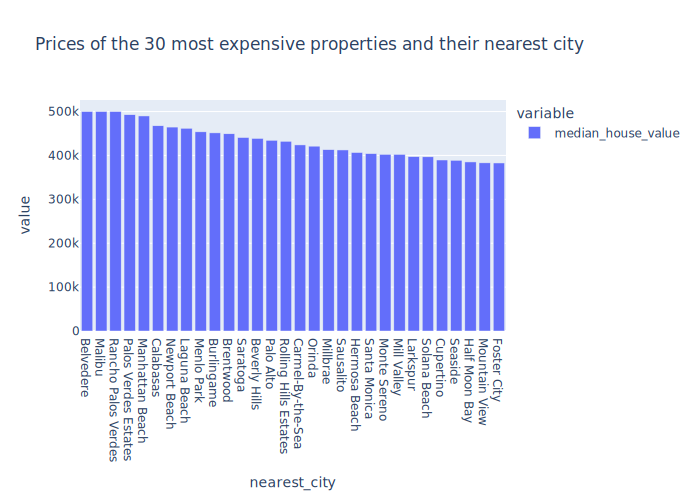

In [56]:
import plotly.io as pio

pio.renderers.default = 'svg'
higher_price_cities = copy.groupby('nearest_city').median_house_value.mean().nlargest(30)
higher_price_cities.plot(kind='bar', backend='plotly', title='Prices of the 30 most expensive properties and their nearest city')

### Distance to the sea

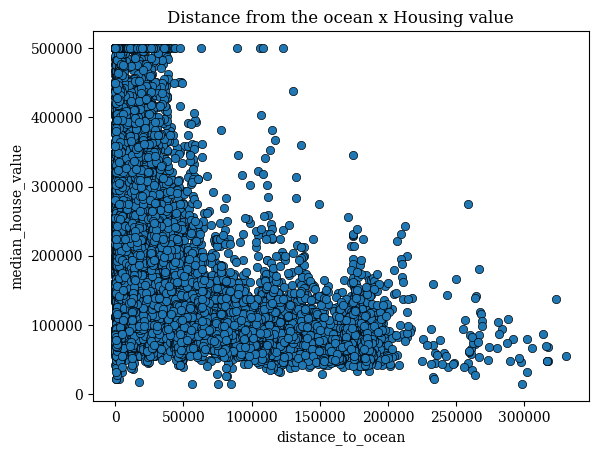

In [57]:
_ = sns.scatterplot(data=copy, x='distance_to_ocean', 
                    y='median_house_value', edgecolor='k')
_ = plt.title('Distance from the ocean x Housing value')

The coast extends to points where they are possibly classified as "<b>INLAND</b>".

### Correlations

In [58]:
copy.select_dtypes(include=np.number).corr()['median_house_value']

lon                        -0.045967
lat                        -0.144160
housing_median_age          0.105623
total_rooms                 0.134153
total_bedrooms              0.049686
population                 -0.024650
households                  0.065843
median_income               0.688075
median_house_value          1.000000
distance_to_ocean          -0.432255
distance_nearest_city      -0.140791
rooms_per_household         0.151948
population_per_household   -0.023737
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

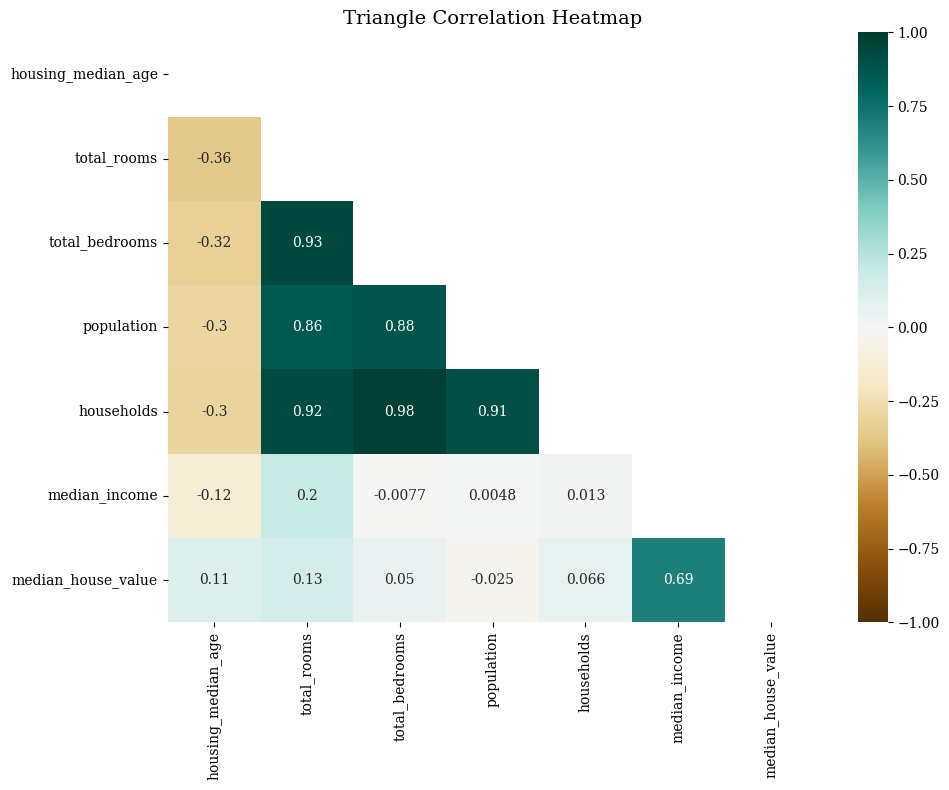

In [59]:
plot_corr_heatmap(data.select_dtypes(include=[np.number]).drop(columns=['lat', 'lon']), fig_size=(10, 8))

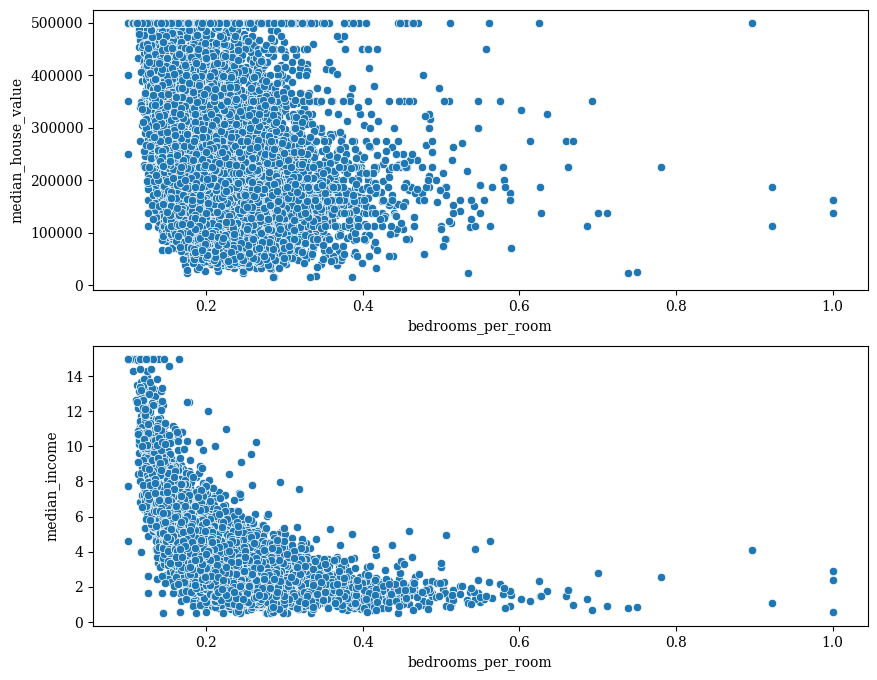

In [60]:
fig, axes = plt.subplots(2, figsize=(10,8))

_ = sns.scatterplot(data=copy, x='bedrooms_per_room', y='median_house_value', ax = axes[0])
_ = sns.scatterplot(data=copy, x='bedrooms_per_room', y='median_income', ax=axes[1])

There seems to be a <b>non-linear</b> relationship on the second graph, but a linear adjustment will be enough.

# Preparing for the modeling
Organization and data cleaning
<hr>

We will use the <code>scikit-learn</code> <code>Pipeline</code> object to apply missing filling, create new variables, train and validate the model. The goal is to make the code cleaner and more organized and <i>avoid data leakage</i>.

In [61]:
data = pd.read_csv('housing.csv').rename(columns={"longitude":'lon',
                                                       "latitude": 'lat'})

data = data[data.median_house_value < 500_000]

X_data = data.drop(columns='median_house_value')
y = data['median_house_value']

data

,lon,lat,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=0.25, random_state=2)

# Pipelines: Feature Selection & Feature Engineering
* Here we will use <code>SmartCorrelatedSelection</code> to select only columns that are not highly correlated, for simplification reasons when entering the data in the app.
* In addition we will import our custom transformer, based on the feature engineering section. 

In [63]:
# importing personalized transformer
%autoreload 2
from utils.combiner import CombinedAttributesAdder

corr_sel = SmartCorrelatedSelection(threshold=0.9, method='pearson')
feature_sel = Pipeline(
    steps=[
        ('corr_selection', corr_sel)
        ]
)

feature_eng = Pipeline(
    steps=[
        ('attr_combiner', CombinedAttributesAdder(add_bedrooms_per_room=True))]
)

In [64]:
feature_eng.fit_transform(X_train)

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,nearest_city,distance_nearest_city,rooms_per_household,bedrooms_per_room
10480,13.0,3320.0,426.0,1432.0,431.0,7.9283,<1H OCEAN,Laguna Hills,1389.560678,7.703016,0.128313
16818,16.0,8676.0,1633.0,5130.0,1574.0,4.8096,NEAR OCEAN,Daly City,4310.800604,5.512071,0.188220
12038,21.0,3491.0,760.0,1920.0,669.0,2.2241,INLAND,Norco,7642.415953,5.218236,0.217703
7585,40.0,1802.0,496.0,2096.0,468.0,2.3542,<1H OCEAN,Compton,460.323357,3.850427,0.275250
8059,33.0,2557.0,731.0,2286.0,700.0,2.3041,<1H OCEAN,Compton,5413.645192,3.652857,0.285882
...,...,...,...,...,...,...,...,...,...,...,...
1111,18.0,2672.0,533.0,1151.0,532.0,2.5670,INLAND,Chico,21453.995303,5.022556,0.199476
19872,35.0,1235.0,369.0,1246.0,341.0,1.4740,INLAND,Visalia,1101.495399,3.621701,0.298785
12397,10.0,2387.0,481.0,863.0,304.0,2.8882,INLAND,La Quinta,3808.104344,7.851974,0.201508
6940,35.0,1326.0,272.0,933.0,267.0,3.4306,<1H OCEAN,Pico Rivera,825.833050,4.966292,0.205128


# Training & Validation of the Model
<hr>

Creating the <code>Pipelines</code> to:
* In numerical attributes: fill missing values and apply a <i>Standard Scaling</i>.
* In categorical attributes: apply a <i>OneHotEncoder</i>.

In [65]:
num_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])  

cat_pipeline = Pipeline(
    steps=[
        ('encoder', OneHotEncoder(handle_unknown="ignore"))
    ])

preprocessor = ColumnTransformer(transformers=[
    ("num_pipe", num_pipeline, make_column_selector(dtype_include='number')),
    ("cat_pipe", cat_pipeline, make_column_selector(dtype_include=object))
])

In [66]:
linear_regression = LinearRegression()

train_pipeline = Pipeline(
    steps=[
        ('feat_eng', feature_eng),
        ('feature_selection', feature_sel),
        ('preprocessor', preprocessor),
        ('regressor', linear_regression)]
)

In [67]:
_ = train_pipeline.fit(X_train, y=y_train)

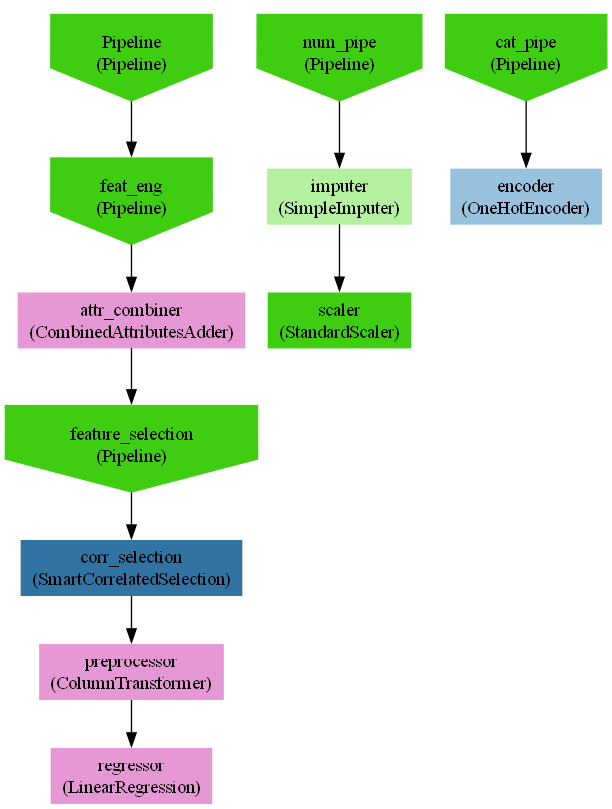

In [69]:
from IPython.display import Image
from dstoolbox.visualization import make_graph

graph = make_graph('Pipeline', train_pipeline)
Image(graph.create_png())

In [70]:
used_columns = train_pipeline[1].get_feature_names_out()
print(f"Columns used: \n{used_columns}")

Columns used: 
['housing_median_age', 'total_rooms', 'population', 'median_income', 'ocean_proximity', 'nearest_city', 'distance_nearest_city', 'rooms_per_household', 'bedrooms_per_room']


# Results and Performance

In [71]:
# Average error of
# with standard deviation of
rmse_scores = cross_val_score(train_pipeline, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error')
rmse = -rmse_scores.mean()
rmse_std = rmse_scores.std()

print(rmse_scores)
print(f"Average error of {rmse:.2f} with standard deviation of {rmse_std:.2f}")

[-46896.31030674 -43682.10876956 -47932.53818438 -49446.49116179
 -50110.29312952 -47250.56345706 -45686.18179908 -49533.10934706
 -44601.00879176 -47405.91235494]
Average error of 47254.45 with standard deviation of 2025.49


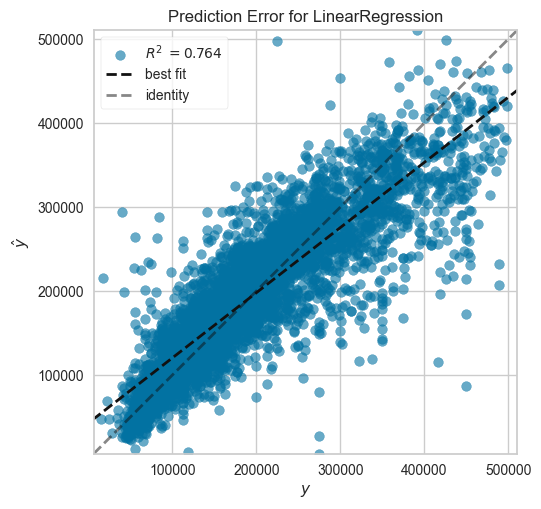

In [74]:
from yellowbrick.regressor import prediction_error

visualizer = prediction_error(train_pipeline, X_train, y_train, X_test, y_test, alpha=0.6)
_ = visualizer.show()

In [75]:
from sklearn.metrics import mean_squared_error

prediction = train_pipeline.predict(X_test)
print(f'Error in test data: {np.sqrt(mean_squared_error(y_test,prediction)):.4f}')

Error in test data: 47290.1786


#### Some points to note:
* A reasonable <b>average error</b> was obtained given the attributes provided and because the <i>dataset</i> is relatively old.
* No intelligent selection of models was used to obtain the model with the best performance; only multiple linear regression was used.

# Pipeline Deployers
<hr>

Creating a more efficient <code>Pipeline</code> to be used in the app

In [76]:
deploy_pipeline = Pipeline(steps=[
    ('feat_eng', feature_eng),
    ('preprocessor', preprocessor),
    ('regression', linear_regression)
])

In [77]:
# saving the model
# it will be saved in a pickle file
import pickle
pickle.dump(deploy_pipeline, open('modl/linear_reg_model.pkl', 'wb'))

# User(Customer) View/ Business Environment
<hr>

This project aims to build an app to help real estate companies properly price their properties. A customer would enter the data in the app and the model would return the average price of the property in that locality. Here we can have two types of errors:

- Estimate the value of the property greater than it is.
- Estimate the value of the property lower than it is.

These two mistakes have different consequences. The first error increases the chance of the customer refusing to purchase the property due to the high price. The second error may result in a loss to the company.

In [78]:
errors = y_test - prediction.round()

In [79]:
errors_1 = errors[errors >= 0]
errors_2 = errors[errors < 0]

pct_error_1 = len(errors_1) / len(errors)
pct_error_2 = len(errors_2) / len(errors)

print(f"Proportion of first type errors: {pct_error_1 * 100:.2f}%")
print(f"Proportion of second type errors: {pct_error_2 * 100:.2f}%")

Proportion of first type errors: 44.65%
Proportion of second type errors: 55.35%


We can see that this model most often <b>overestimates</b> the property value.